# Split-Training, Testing, Validation. Datagenerator. Model.

In [79]:
(1)
# Data Processing and Visualization
import os
import random
import glob
import re
import imgaug.augmenters as iaa

# Data Manipulation and Analysis
import numpy as np
import pandas as pd
import math
import imgaug.augmenters as iaa  # For mild data augmentation

# Image Processing and Visualization
import matplotlib.pyplot as plt
import cv2
from skimage import io
from PIL import Image
# Deep Learning Framework (TensorFlow/Keras)
import tensorflow as tf

# Specific TensorFlow/Keras Components
from tensorflow.keras import optimizers
from tensorflow.keras import layers, models
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import Sequence, plot_model
from tensorflow.keras.callbacks import (
    ReduceLROnPlateau, 
    EarlyStopping, 
    ModelCheckpoint, 
    LearningRateScheduler
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import categorical_crossentropy
import tensorflow.keras.backend as K

# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, normalize
from IPython.display import display
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import binary_crossentropy


Datamap imports the path of images and store them to a variable

In [80]:
(2)
datamap = []

# Specify the path to your dataset on your Windows machine
dataset_path = "Seg_MRI"

# Iterate over subdirectories in the specified path
for sub_dir_path in glob.glob(dataset_path + "/*"):
    # Check if the current path is a directory
    if os.path.isdir(sub_dir_path):
        # Extract the tumor type from the directory name
        dir_name = os.path.basename(sub_dir_path)

        # Iterate over files in the directory
        for filename in os.listdir(sub_dir_path):
            # Construct the full path to the image file
            image_path = os.path.join(sub_dir_path, filename)
            
            # Load the image as an array
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            
            # Check if the image is successfully loaded
            if image is not None:
                # Append a dictionary to the datamap
                datamap.append({
                    'tumor_type': dir_name,
                    'file_name': filename,
                    'file_path': image_path,  # Include the full file path
                    'image': image
                })

# Display the datamap
for entry in datamap[:10]:  # Display only the first 10 entries
    print(f"Tumor Type: {entry['tumor_type']}, File Name: {entry['file_name']}, File Path: {entry['file_path']}, Image Shape: {entry['image'].shape}")


Tumor Type: Glioblastoma, File Name: TCGA_CS_4941_19960909_11.tif, File Path: Seg_MRI\Glioblastoma\TCGA_CS_4941_19960909_11.tif, Image Shape: (256, 256, 3)
Tumor Type: Glioblastoma, File Name: TCGA_CS_4941_19960909_11_mask.tif, File Path: Seg_MRI\Glioblastoma\TCGA_CS_4941_19960909_11_mask.tif, Image Shape: (256, 256, 3)
Tumor Type: Glioblastoma, File Name: TCGA_CS_4941_19960909_12.tif, File Path: Seg_MRI\Glioblastoma\TCGA_CS_4941_19960909_12.tif, Image Shape: (256, 256, 3)
Tumor Type: Glioblastoma, File Name: TCGA_CS_4941_19960909_12_mask.tif, File Path: Seg_MRI\Glioblastoma\TCGA_CS_4941_19960909_12_mask.tif, Image Shape: (256, 256, 3)
Tumor Type: Glioblastoma, File Name: TCGA_CS_4941_19960909_13.tif, File Path: Seg_MRI\Glioblastoma\TCGA_CS_4941_19960909_13.tif, Image Shape: (256, 256, 3)
Tumor Type: Glioblastoma, File Name: TCGA_CS_4941_19960909_13_mask.tif, File Path: Seg_MRI\Glioblastoma\TCGA_CS_4941_19960909_13_mask.tif, Image Shape: (256, 256, 3)
Tumor Type: Gliomas, File Name: TC

Coverting the datamap to dataframe

In [81]:
(3)
# Convert the data_map to a pandas DataFrame
datamap_df = pd.DataFrame(datamap)
print(datamap_df.head())
# print(df)

     tumor_type                          file_name  \
0  Glioblastoma       TCGA_CS_4941_19960909_11.tif   
1  Glioblastoma  TCGA_CS_4941_19960909_11_mask.tif   
2  Glioblastoma       TCGA_CS_4941_19960909_12.tif   
3  Glioblastoma  TCGA_CS_4941_19960909_12_mask.tif   
4  Glioblastoma       TCGA_CS_4941_19960909_13.tif   

                                           file_path  \
0  Seg_MRI\Glioblastoma\TCGA_CS_4941_19960909_11.tif   
1  Seg_MRI\Glioblastoma\TCGA_CS_4941_19960909_11_...   
2  Seg_MRI\Glioblastoma\TCGA_CS_4941_19960909_12.tif   
3  Seg_MRI\Glioblastoma\TCGA_CS_4941_19960909_12_...   
4  Seg_MRI\Glioblastoma\TCGA_CS_4941_19960909_13.tif   

                                               image  
0  [[[1, 1, 0], [1, 1, 0], [2, 2, 0], [2, 2, 0], ...  
1  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...  
2  [[[1, 4, 0], [2, 2, 0], [3, 2, 0], [2, 4, 0], ...  
3  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...  
4  [[[2, 3, 0], [3, 1, 0], [2, 2, 0], [1, 3, 0], ...  


In [82]:
(4)
# Filtering image paths and mask paths
df_imgs = datamap_df[~datamap_df['file_path'].str.contains("mask")]
df_masks = datamap_df[datamap_df['file_path'].str.contains("mask")]

# Creating a dictionary for mask paths with tumor type
mask_dict = {path[:-9]: (path, tumor_type) for path, tumor_type in zip(df_masks["file_path"].values, df_masks["tumor_type"].values)}

# Pairing each image with its corresponding mask and tumor type
pairs = []
for image_path, tumor_type in zip(df_imgs["file_path"].values, df_imgs["tumor_type"].values):
    base_path = image_path[:-4]  # Remove the '.tif' extension
    mask_info = mask_dict.get(base_path)  # Retrieve the corresponding mask path and tumor type
    if mask_info:
        mask_path, mask_tumor_type = mask_info
        # Ensure the tumor type matches for both image and mask
        if tumor_type == mask_tumor_type:
            pairs.append({'Tumor_Type': tumor_type, 'Image_Path': image_path, 'Mask_Path': mask_path})

# Convert pairs list to DataFrame
pairs_df = pd.DataFrame(pairs)

# Sort the DataFrame by 'Tumor Type'
final_df = pairs_df.sort_values(by='Tumor_Type').reset_index(drop=True)

# Display the updated DataFrame
print(final_df.head())  # Shows the first few rows


     Tumor_Type                                         Image_Path  \
0  Glioblastoma  Seg_MRI\Glioblastoma\TCGA_CS_4941_19960909_11.tif   
1  Glioblastoma  Seg_MRI\Glioblastoma\TCGA_CS_4941_19960909_12.tif   
2  Glioblastoma  Seg_MRI\Glioblastoma\TCGA_CS_4941_19960909_13.tif   
3       Gliomas       Seg_MRI\Gliomas\TCGA_CS_4941_19960909_14.tif   
4       Gliomas       Seg_MRI\Gliomas\TCGA_CS_4941_19960909_15.tif   

                                           Mask_Path  
0  Seg_MRI\Glioblastoma\TCGA_CS_4941_19960909_11_...  
1  Seg_MRI\Glioblastoma\TCGA_CS_4941_19960909_12_...  
2  Seg_MRI\Glioblastoma\TCGA_CS_4941_19960909_13_...  
3  Seg_MRI\Gliomas\TCGA_CS_4941_19960909_14_mask.tif  
4  Seg_MRI\Gliomas\TCGA_CS_4941_19960909_15_mask.tif  


In [83]:
final_df

,Tumor_Type,Image_Path,Mask_Path
0,Glioblastoma,Seg_MRI\Glioblastoma\TCGA_CS_4941_19960909_11.tif,Seg_MRI\Glioblastoma\TCGA_CS_4941_19960909_11_...
1,Glioblastoma,Seg_MRI\Glioblastoma\TCGA_CS_4941_19960909_12.tif,Seg_MRI\Glioblastoma\TCGA_CS_4941_19960909_12_...
2,Glioblastoma,Seg_MRI\Glioblastoma\TCGA_CS_4941_19960909_13.tif,Seg_MRI\Glioblastoma\TCGA_CS_4941_19960909_13_...
3,Gliomas,Seg_MRI\Gliomas\TCGA_CS_4941_19960909_14.tif,Seg_MRI\Gliomas\TCGA_CS_4941_19960909_14_mask.tif
4,Gliomas,Seg_MRI\Gliomas\TCGA_CS_4941_19960909_15.tif,Seg_MRI\Gliomas\TCGA_CS_4941_19960909_15_mask.tif
5,Gliomas,Seg_MRI\Gliomas\TCGA_CS_4941_19960909_16.tif,Seg_MRI\Gliomas\TCGA_CS_4941_19960909_16_mask.tif
6,Gliomas,Seg_MRI\Gliomas\TCGA_CS_4941_19960909_17.tif,Seg_MRI\Gliomas\TCGA_CS_4941_19960909_17_mask.tif


Displaying the images before pre-processing

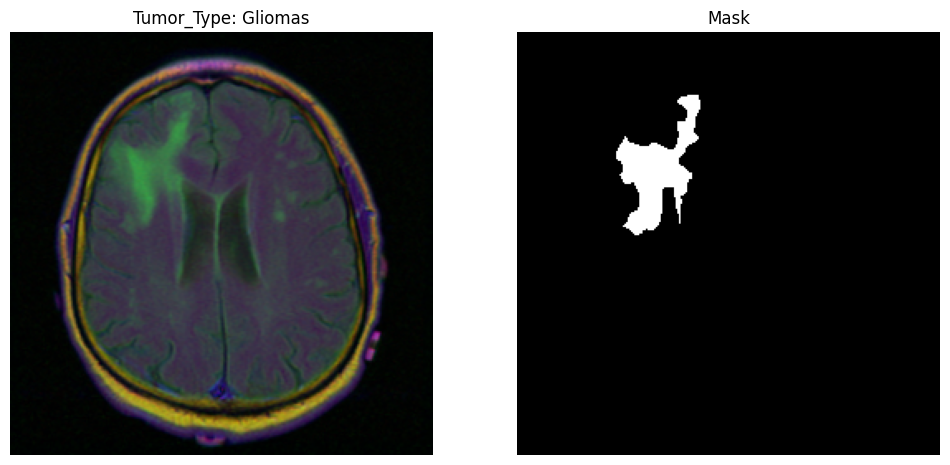

In [84]:
(5)
# Randomly select a pair
idx = random.randint(0, len(final_df) - 1)
selected_row = final_df.iloc[idx]

# Paths
img_path = selected_row['Image_Path']
mask_path = selected_row['Mask_Path']
tumor_type = selected_row['Tumor_Type']

# Load the image and mask
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Load mask in grayscale

# Display the image, mask, and tumor type
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title(f'Tumor_Type: {tumor_type}')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title('Mask')
plt.axis('off')

plt.show()


Display with Mask overlay

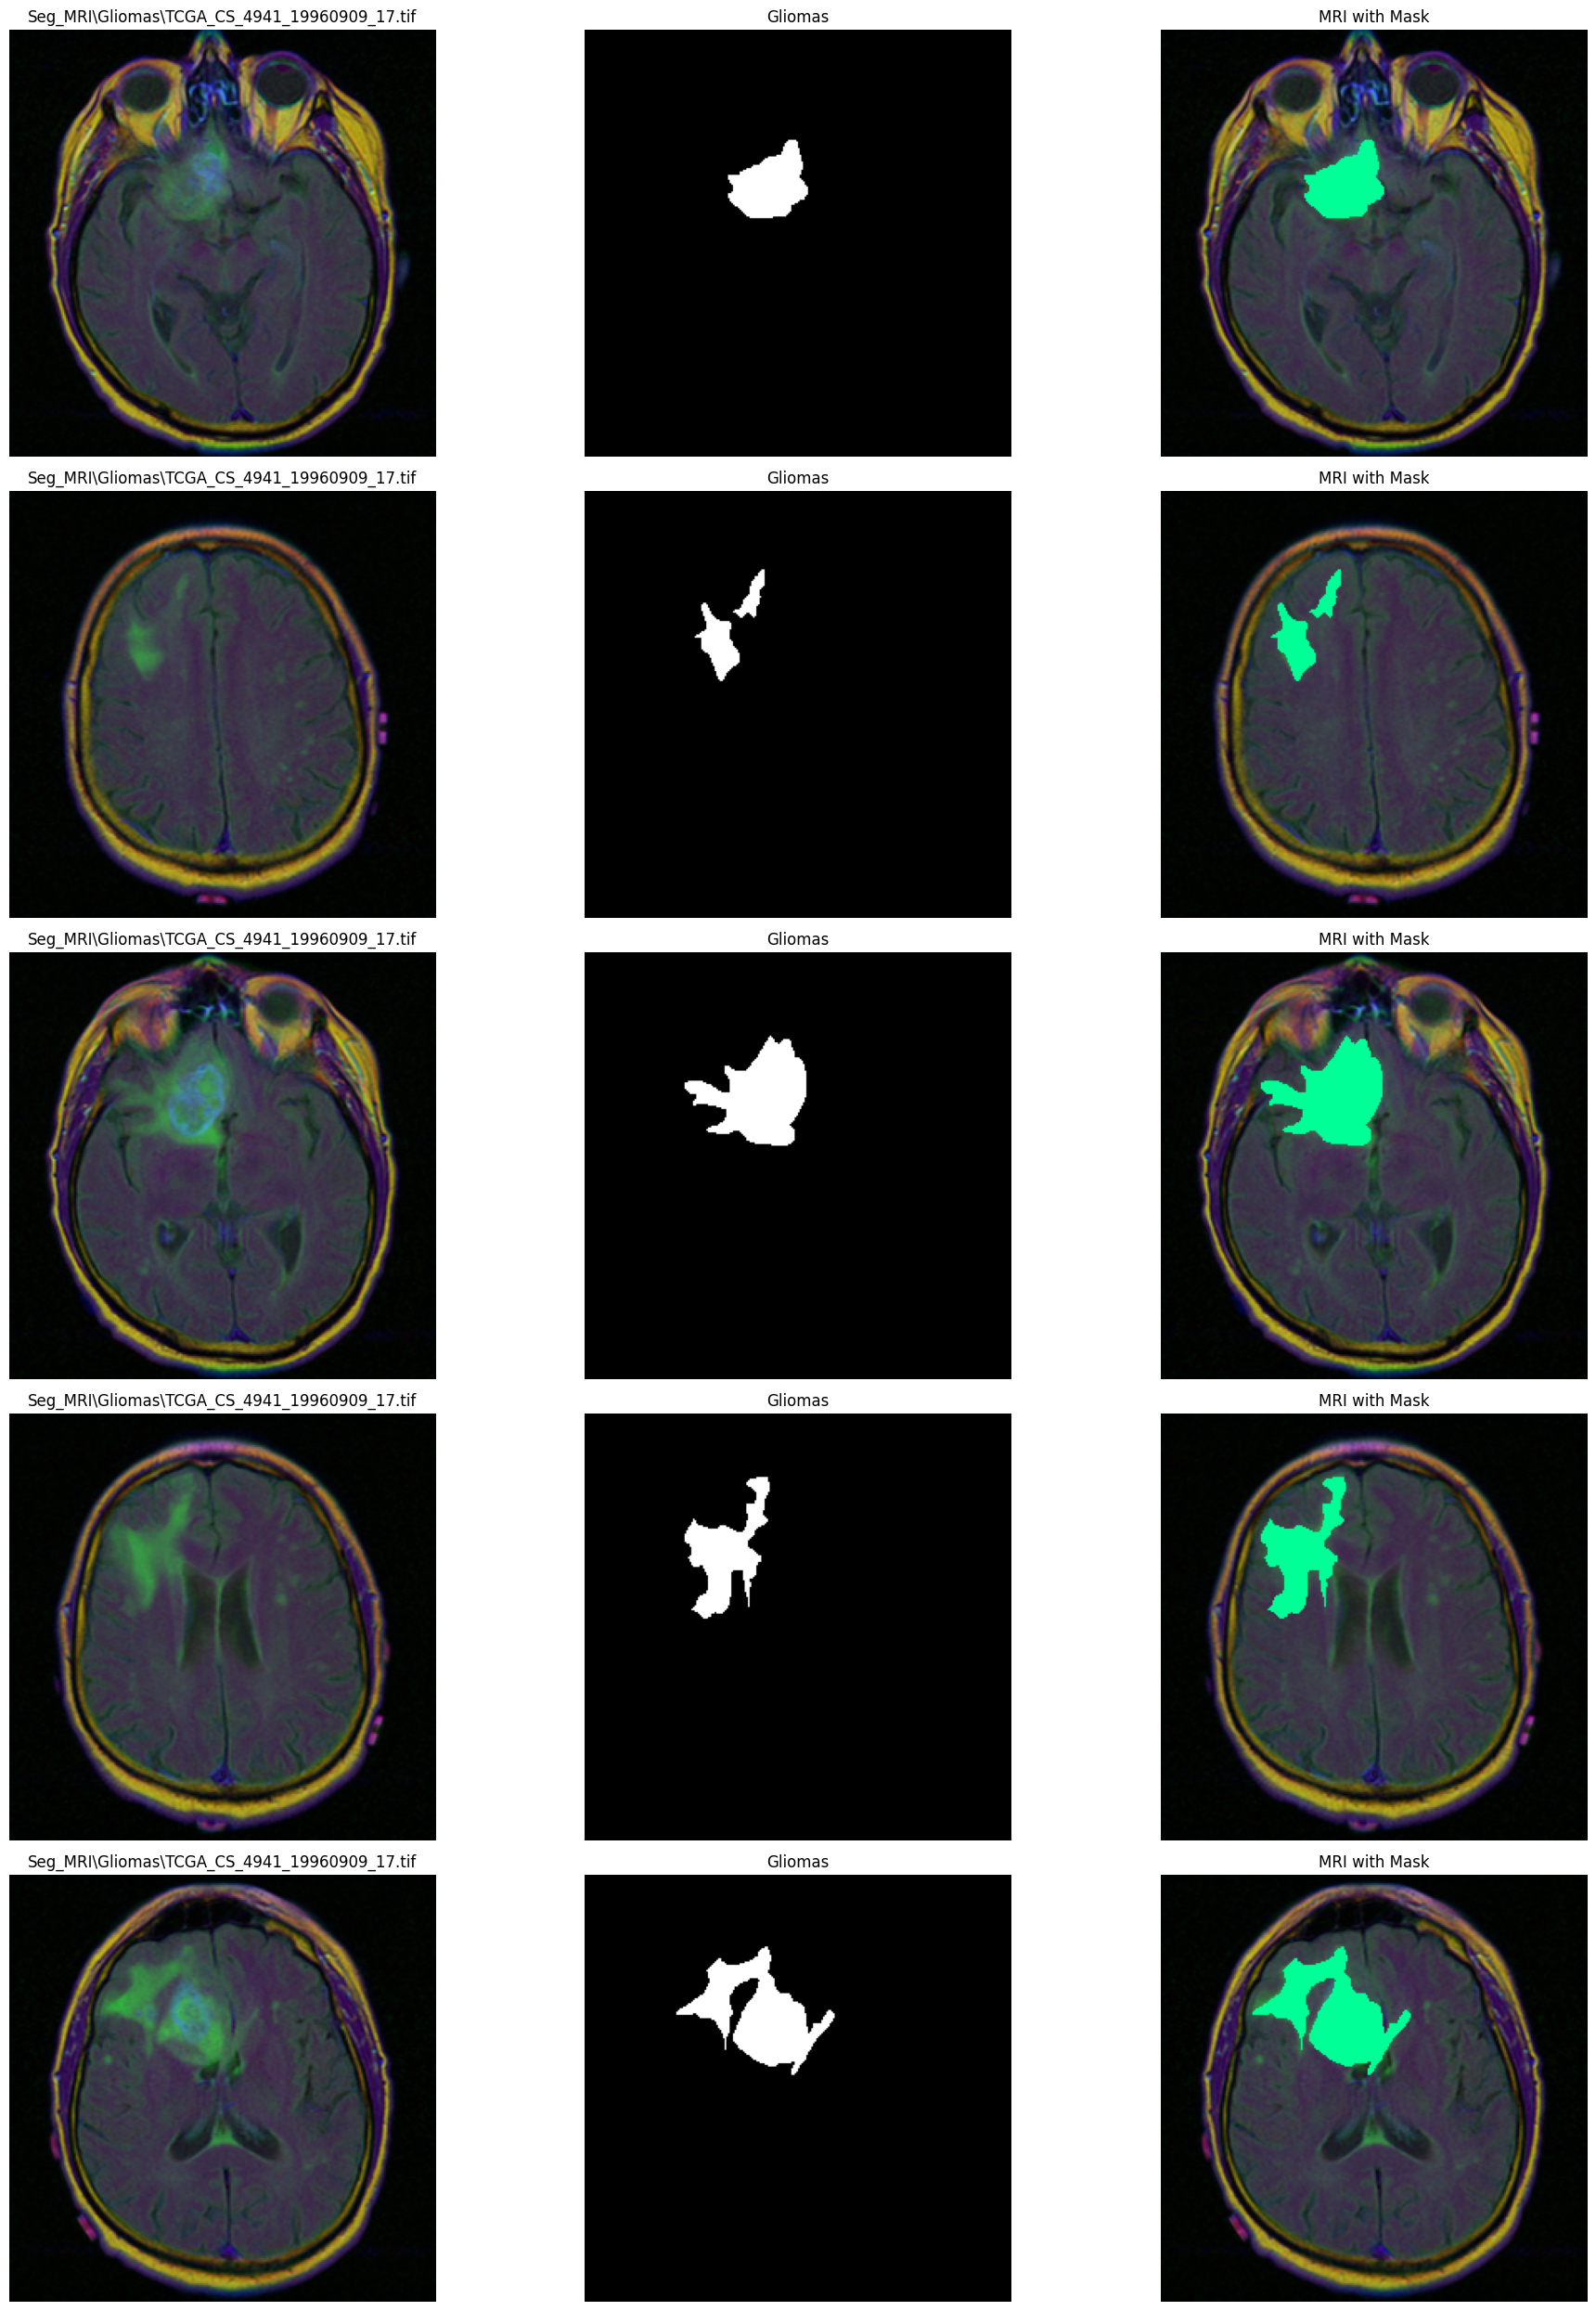

In [85]:
(6)

# Randomly select 5 unique indices from the DataFrame
random_indices = random.sample(range(len(final_df)), 5)

# Initialize the figure for plotting
fig, axs = plt.subplots(5, 3, figsize=(20, 25))  # 5 rows, 3 columns

# Iterate through the randomly selected indices
for count, idx in enumerate(random_indices):
    row = final_df.iloc[idx]
    
    # Load the mask image
    mask_path = row['Mask_Path']  # Assuming 'mask_path' is the column name for mask paths
    mask = io.imread(mask_path)
    
    # Load the brain MRI image
    img_path = row['Image_Path']  # Assuming 'image_path' is the column name
    img = io.imread(img_path)
    
    # Display the brain MRI
    axs[count][0].imshow(img)
    axs[count][0].set_title(image_path)
    axs[count][0].axis('off')  # Hide axis for better visualization

    # Display the mask
    axs[count][1].imshow(mask, cmap='gray')
    axs[count][1].set_title(tumor_type)
    axs[count][1].axis('off')

    # Overlay the mask on the brain MRI
    img_overlay = img.copy()
    img_overlay[mask == 255] = [0,255,150]  # Overlay color where the mask is present
    axs[count][2].imshow(img_overlay)
    axs[count][2].set_title("MRI with Mask")
    axs[count][2].axis('off')

fig.tight_layout()
plt.show()


Labeling Tumor Types

In [86]:
(7)

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and return encoded labels
final_df['Tumor_Type_Int'] = label_encoder.fit_transform(final_df['Tumor_Type'])

# Now, 'Tumor Type Int' column contains the integer labels for the tumor types
print(final_df[['Tumor_Type', 'Tumor_Type_Int']].head())


     Tumor_Type  Tumor_Type_Int
0  Glioblastoma               0
1  Glioblastoma               0
2  Glioblastoma               0
3       Gliomas               1
4       Gliomas               1


In [87]:
(8)
# inverse mapping from integer labels back to original string labels
inverse_mapping = {i: label for i, label in enumerate(label_encoder.classes_)}

# Get unique encoded labels from 'Tumor_Type_Int' column
unique_encoded_labels = final_df['Tumor_Type_Int'].unique()

# Sort the unique labels to ensure they are in ascending order
unique_encoded_labels.sort()

# Display each unique encoded label and its corresponding original tumor type
for encoded_label in unique_encoded_labels:
    original_label = inverse_mapping[encoded_label]
    print(f"Encoded Label: {encoded_label}, Original Tumor Type: {original_label}")


Encoded Label: 0, Original Tumor Type: Glioblastoma
Encoded Label: 1, Original Tumor Type: Gliomas


In [90]:
(9)
# Adding a new column 'Original_Tumor_Type' to final_df that maps 'Tumor_Type_Int' back to the original string labels
final_df['Original_Tumor_Type'] = final_df['Tumor_Type_Int'].map(inverse_mapping)

# Now, 'final_df' contains a new column 'Original_Tumor_Type' with the original string labels
print(final_df[['Tumor_Type_Int', 'Original_Tumor_Type']].head())


   Tumor_Type_Int Original_Tumor_Type
0               0        Glioblastoma
1               0        Glioblastoma
2               0        Glioblastoma
3               1             Gliomas
4               1             Gliomas


In [91]:
final_df

,Tumor_Type,Image_Path,Mask_Path,Tumor_Type_Int,Original_Tumor_Type
0,Glioblastoma,Seg_MRI\Glioblastoma\TCGA_CS_4941_19960909_11.tif,Seg_MRI\Glioblastoma\TCGA_CS_4941_19960909_11_...,0,Glioblastoma
1,Glioblastoma,Seg_MRI\Glioblastoma\TCGA_CS_4941_19960909_12.tif,Seg_MRI\Glioblastoma\TCGA_CS_4941_19960909_12_...,0,Glioblastoma
2,Glioblastoma,Seg_MRI\Glioblastoma\TCGA_CS_4941_19960909_13.tif,Seg_MRI\Glioblastoma\TCGA_CS_4941_19960909_13_...,0,Glioblastoma
3,Gliomas,Seg_MRI\Gliomas\TCGA_CS_4941_19960909_14.tif,Seg_MRI\Gliomas\TCGA_CS_4941_19960909_14_mask.tif,1,Gliomas
4,Gliomas,Seg_MRI\Gliomas\TCGA_CS_4941_19960909_15.tif,Seg_MRI\Gliomas\TCGA_CS_4941_19960909_15_mask.tif,1,Gliomas
5,Gliomas,Seg_MRI\Gliomas\TCGA_CS_4941_19960909_16.tif,Seg_MRI\Gliomas\TCGA_CS_4941_19960909_16_mask.tif,1,Gliomas
6,Gliomas,Seg_MRI\Gliomas\TCGA_CS_4941_19960909_17.tif,Seg_MRI\Gliomas\TCGA_CS_4941_19960909_17_mask.tif,1,Gliomas


# Split data into training, testing, validation

In [97]:
(10)

# Split the main dataset into training and a temporary test set with 15% of the data
X_train, X_temp_test = train_test_split(final_df, test_size=0.15, random_state=42)

# Split the temporary test set into validation and test sets equally
X_val, X_test = train_test_split(X_temp_test, test_size=0.5, random_state=42)

# Display the sizes of each dataset
print(f"Train size is {len(X_train)}, validation size is {len(X_val)}, & test size is {len(X_test)}")

# Extract 'Image_Path' and 'Mask_Path' for training, validation, and test datasets
train_ids = list(X_train['Image_Path'])
train_masks = list(X_train['Mask_Path'])

val_ids = list(X_val['Image_Path'])
val_masks = list(X_val['Mask_Path'])

test_ids = list(X_test['Image_Path'])
test_masks = list(X_test['Mask_Path'])


Train size is 5, validation size is 1, & test size is 1


# Data Generator

In [140]:
(11)

class CustomDataGenerator(Sequence):
    def __init__(self, image_paths, mask_paths, labels, batch_size, image_size, shuffle=True):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.labels = labels
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.image_paths))
        self.on_epoch_end()

        self.augmenter = iaa.Sequential([
            iaa.Fliplr(0.5),  # Horizontal flips
            iaa.Affine(rotate=(-5, 5)),  # Rotate by -5 to +5 degrees
            iaa.Multiply((0.95, 1.05)),  # Change brightness
        ])
    
    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__generate_Xy(batch_indices)
        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __generate_Xy(self, batch_indices):
        X = np.empty((len(batch_indices), *self.image_size, 1), dtype=np.float32)
        y = np.empty((len(batch_indices)), dtype=int)
        masks = np.empty((len(batch_indices), *self.image_size, 1), dtype=np.float32)

        for i, idx in enumerate(batch_indices):
            image_path = self.image_paths[idx]
            mask_path = self.mask_paths[idx]
            
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            image = cv2.resize(image, self.image_size)
            mask = cv2.resize(mask, self.image_size)

            image = np.expand_dims(image, axis=-1)
            mask = np.expand_dims(mask, axis=-1)

            # Ensure images and masks are normalized
            image = image.astype(np.float32) / 255.0
            mask = mask.astype(np.float32) / 255.0

            # Apply augmentation simultaneously to image and mask
            if self.augmenter is not None:
                seq_det = self.augmenter.to_deterministic()  # Ensure same augmentation is applied to image and mask
                image = seq_det.augment_image(image.squeeze())
                mask = seq_det.augment_image(mask.squeeze())

                image = np.expand_dims(image, axis=-1)
                mask = np.expand_dims(mask, axis=-1)

            X[i,] = image
            masks[i,] = mask
            y[i] = self.labels[idx]

        return [X, masks], y  # Adjust the return statement as per your model's input

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def get_image_path_and_label(self, index):
        """Fetch the image path, mask path, and label for a given index."""
        # Use the original index to fetch the correct image path and label
        # This assumes that self.image_paths, self.mask_paths, and self.labels are aligned and have the same order.
        image_path = self.image_paths[index]
        mask_path = self.mask_paths[index]  # Assuming mask_paths are stored in the same order as image_paths
        label = self.labels[index]
        return image_path, mask_path, label


# Instantiate custom data generators
train_generator = CustomDataGenerator(
    image_paths=X_train['Image_Path'].tolist(),
    mask_paths=X_train['Mask_Path'].tolist(),
    labels=X_train['Tumor_Type_Int'].tolist(),
    batch_size=16,
    image_size=(256, 256),
    shuffle=True
)

val_generator = CustomDataGenerator(
    image_paths=X_val['Image_Path'].tolist(),
    mask_paths=X_val['Mask_Path'].tolist(),
    labels=X_val['Tumor_Type_Int'].tolist(),
    batch_size=16,
    image_size=(256, 256),
    shuffle=False
)


Visuals of Preprocessing

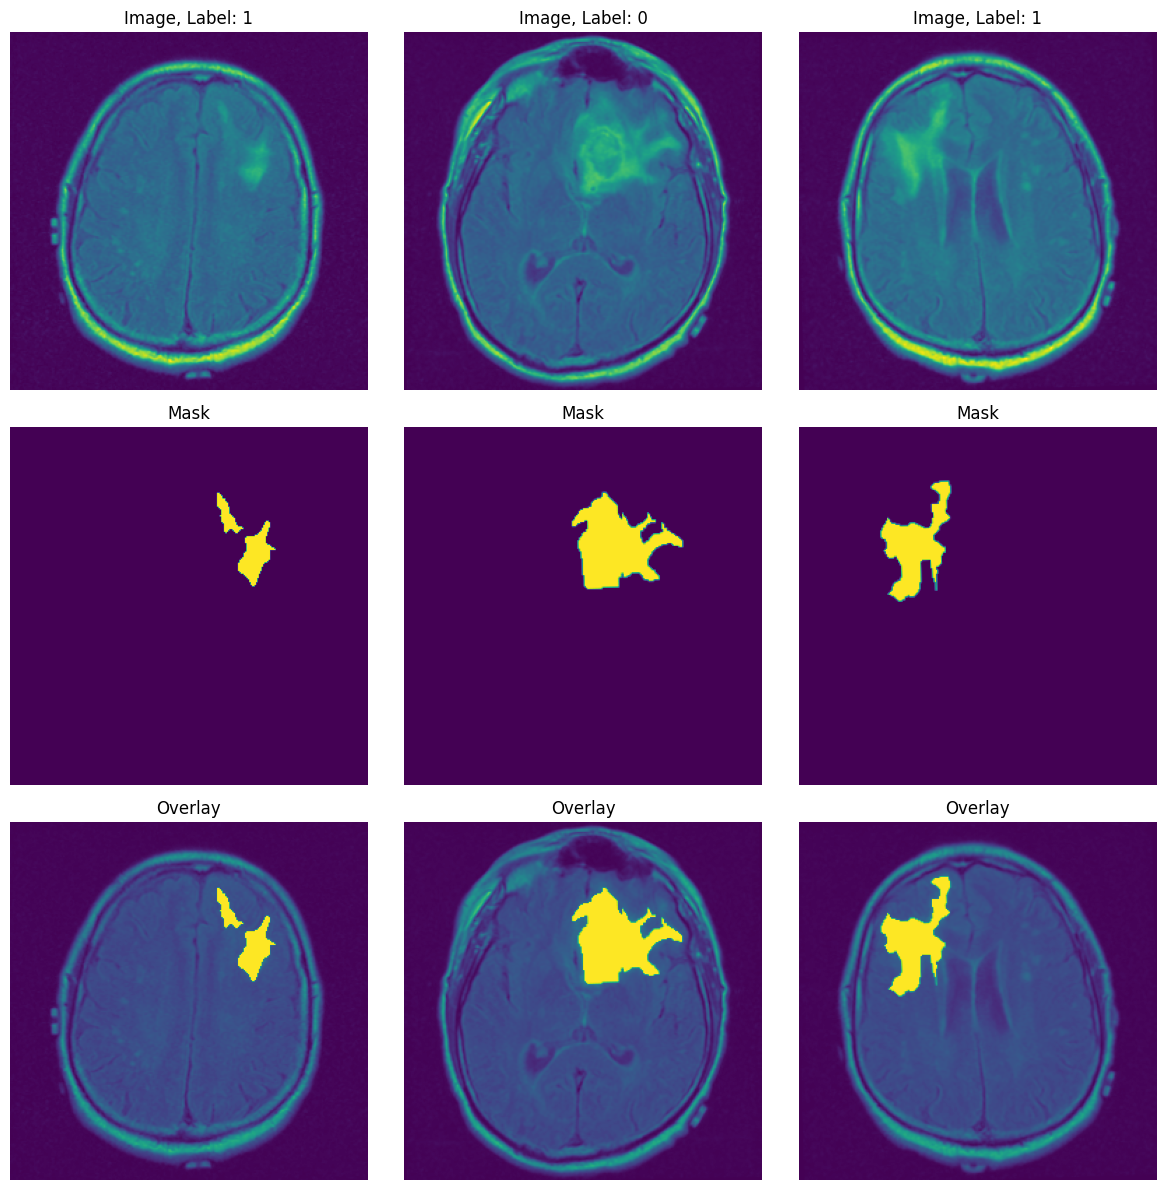

In [141]:
(12)
import matplotlib.pyplot as plt

# Choose the first batch for display
batch_index = 0
X_batch, y_batch = train_generator.__getitem__(batch_index)

# Number of images to display, fixed to the first three of a batch
num_images_to_display = 3

plt.figure(figsize=(12, num_images_to_display * 4))
for i in range(num_images_to_display):
    # Access the image from the batch; ensure we're correctly handling the shape
    image = X_batch[0][i].squeeze()  # Access first element of X_batch if it's a list [X, masks]
    mask = X_batch[1][i].squeeze()  # Access second element of X_batch for masks if it's structured as [X, masks]
    label = y_batch[i]  # Label for the current image

    # Plot the original image
    plt.subplot(3, num_images_to_display, i + 1)
    plt.imshow(image)
    plt.title(f"Image, Label: {label}")
    plt.axis('off')

    # Plot the mask
    plt.subplot(3, num_images_to_display, num_images_to_display + i + 1)
    plt.imshow(mask)
    plt.title("Mask")
    plt.axis('off')

    # Plot the overlay (optional, adjust as needed)
    overlay = np.maximum(image, mask)  # Simple way to overlay, adjust as needed
    plt.subplot(3, num_images_to_display, 2 * num_images_to_display + i + 1)
    plt.imshow(overlay)
    plt.title("Overlay")
    plt.axis('off')

plt.tight_layout()
plt.show()




# Model

In [148]:
(13)

def conv_block(input_tensor, num_filters):
    x = layers.Conv2D(num_filters, (3, 3), activation="relu", padding="same")(input_tensor)
    x = layers.Conv2D(num_filters, (3, 3), activation="relu", padding="same")(x)
    return x

def encoder_block(input_tensor, num_filters):
    x = conv_block(input_tensor, num_filters)
    p = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)
    return x, p  # x is for skip connection, p is the pooled output

def custom_vgg16_encoder(input_tensor):
    s1, p1 = encoder_block(input_tensor, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)
    bridge = conv_block(p4, 512)
    return bridge, [s4, s3, s2, s1]  # Returning skip connections as a list

def decoder_block(input_tensor, skip_features, num_filters):
    x = layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input_tensor)
    if skip_features is not None:  # Allows for flexible decoder use without skip connections
        x = layers.concatenate([x, skip_features], axis=-1)
    x = conv_block(x, num_filters)
    return x

def build_custom_unet_vgg16(input_shape, num_classes=None):
    inputs = layers.Input(shape=input_shape)
    bridge, skips = custom_vgg16_encoder(inputs)
    
    x = bridge
    for i, num_filters in enumerate([512, 256, 128, 64]):
        if i < len(skips):  # To avoid index error for the last decoder block without skip connection
            x = decoder_block(x, skips[i], num_filters)
        else:
            x = decoder_block(x, None, num_filters)
    
    if num_classes is None:
        num_classes = final_df['Tumor_Type_Int'].nunique()  # Assuming final_df exists and num_classes is dynamic
    
    outputs = layers.Conv2D(num_classes, (1, 1), activation="softmax")(x)
    model = models.Model(inputs, outputs, name="Custom_VGG16_U-Net")
    return model

# Assuming the existence of final_df for dynamic class count
input_shape = (256, 256, 3)
custom_vgg16_unet_model = build_custom_unet_vgg16(input_shape)

custom_vgg16_unet_model.summary()



Model: "Custom_VGG16_U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_76 (Conv2D)          (None, 256, 256, 64)         1792      ['input_7[0][0]']             
                                                                                                  
 conv2d_77 (Conv2D)          (None, 256, 256, 64)         36928     ['conv2d_76[0][0]']           
                                                                                                  
 max_pooling2d_16 (MaxPooli  (None, 128, 128, 64)         0         ['conv2d_77[0][0]']           
 ng2D)                                                                           

Custom Loss Function

In [ ]:
(10)
epsilon = 1e-5
smooth = 1

def categorical_tversky_index(y_true, y_pred, alpha=0.7):
    # Get the dynamic shape
    shape = tf.shape(y_true)
    y_true = K.reshape(y_true, [-1, shape[-3], shape[-2], shape[-1]])
    y_pred = K.reshape(y_pred, [-1, shape[-3], shape[-2], shape[-1]])

    # Calculate Tversky index for each pixel and then average over all pixels
    true_positives = K.sum(y_true * y_pred, axis=[1, 2])
    false_negatives = K.sum(y_true * (1 - y_pred), axis=[1, 2])
    false_positives = K.sum((1 - y_true) * y_pred, axis=[1, 2])

    tversky_index = (true_positives + smooth) / (true_positives + alpha * false_negatives + (1 - alpha) * false_positives + smooth)
    return K.mean(tversky_index)


def focal_tversky_loss(y_true, y_pred, gamma=0.75):
    tversky_index = categorical_tversky_index(y_true, y_pred)
    return K.pow((1 - tversky_index), gamma)

# Custom loss function
def modified_categorical_crossentropy(y_true, y_pred):
    return tf.keras.losses.categorical_crossentropy(y_true, y_pred) + (1 - categorical_tversky_index(y_true, y_pred))



Checkpoints

In [ ]:
(11)
class SaveHistoryCallback(tf.keras.callbacks.Callback):
    def __init__(self, csv_filename="Model_Weights/training_history.csv"):
        super(SaveHistoryCallback, self).__init__()
        self.csv_filename = csv_filename
        self.epoch_history = []
        # Load existing history if it exists to maintain continuity
        if os.path.exists(self.csv_filename):
            self.epoch_history = pd.read_csv(self.csv_filename).to_dict('records')

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        # Adjust epoch number based on existing records
        current_epoch = epoch + 1 if not self.epoch_history else self.epoch_history[-1].get('epoch', epoch) + 1
        logs['epoch'] = current_epoch
        self.epoch_history.append(logs)
        # Ensure 'epoch' is the first column
        df = pd.DataFrame(self.epoch_history)
        cols = ['epoch'] + [col for col in df.columns if col != 'epoch']
        df = df[cols]
        # Save updated history ensuring 'epoch' is first
        df.to_csv(self.csv_filename, index=False)

# Instantiate callbacks
csv_filename = "Model_Weights/training_history.csv"
save_history_callback = SaveHistoryCallback(csv_filename)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
checkpointer = ModelCheckpoint(filepath="Model_Weights/brain_tumor_model_weights.hdf5", verbose=1, save_best_only=True, save_weights_only=False, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=3, min_lr=0.000001, verbose=1)

# Assuming custom_rgb_model is already defined
adam = tf.keras.optimizers.Adam(learning_rate=0.001, epsilon=0.1)
custom_rgb_model.compile(optimizer=adam, loss=modified_categorical_crossentropy, metrics=['accuracy'])



setup epoch latest value

In [ ]:
(12)
# Check and read the existing CSV, if available
if os.path.exists(csv_filename):
    existing_df = pd.read_csv(csv_filename)
    # Ensure 'epoch' is the first column by reordering if it's not
    if 'epoch' in existing_df.columns:
        cols = ['epoch'] + [col for col in existing_df.columns if col != 'epoch']
        existing_df = existing_df[cols]
    existing_df.to_csv(csv_filename, index=False)
else:
    # If the CSV doesn't exist, no action is needed here
    pass

Loading the model checkpoint

In [ ]:
(13)
model_path = "Model_Weights/brain_tumor_model_weights.hdf5"
if os.path.exists(model_path):
    custom_rgb_model = load_model(model_path, custom_objects={'modified_categorical_crossentropy': modified_categorical_crossentropy})
    print("Model loaded successfully.")
else:
    print("Starting training from scratch.")

Model loaded successfully.


Epochs

In [ ]:
(14)
# Total number of epochs to train
total_epochs = 400
# Train the model with the callbacks
history = custom_rgb_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=total_epochs,
    callbacks=[early_stopping, reduce_lr, checkpointer, save_history_callback],
    verbose=1
)

# Access the entire training history
entire_training_history = save_history_callback.epoch_history


Epoch 1/400

2/2 [==============================] - ETA: 0s - loss: 2.9806 - accuracy: 0.1521 
Epoch 1: val_loss improved from inf to 1.95836, saving model to Model_Weights\brain_tumor_model_weights.hdf5


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 86s 44s/step - loss: 2.9806 - accuracy: 0.1521 - val_loss: 1.9584 - val_accuracy: 0.5938 - lr: 0.0010 - epoch: 16.0000
Epoch 2/400
2/2 [==============================] - ETA: 0s - loss: 2.9837 - accuracy: 0.1529 
Epoch 2: val_loss improved from 1.95836 to 1.95831, saving model to Model_Weights\brain_tumor_model_weights.hdf5


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 75s 38s/step - loss: 2.9837 - accuracy: 0.1529 - val_loss: 1.9583 - val_accuracy: 0.5938 - lr: 0.0010 - epoch: 17.0000
Epoch 3/400
2/2 [==============================] - ETA: 0s - loss: 2.9789 - accuracy: 0.1540 
Epoch 3: val_loss improved from 1.95831 to 1.95828, saving model to Model_Weights\brain_tumor_model_weights.hdf5


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 69s 38s/step - loss: 2.9789 - accuracy: 0.1540 - val_loss: 1.9583 - val_accuracy: 0.5938 - lr: 0.0010 - epoch: 18.0000
Epoch 4/400
2/2 [==============================] - ETA: 0s - loss: 2.9710 - accuracy: 0.1555 
Epoch 4: val_loss improved from 1.95828 to 1.95826, saving model to Model_Weights\brain_tumor_model_weights.hdf5


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 73s 38s/step - loss: 2.9710 - accuracy: 0.1555 - val_loss: 1.9583 - val_accuracy: 0.5938 - lr: 0.0010 - epoch: 19.0000
Epoch 5/400
2/2 [==============================] - ETA: 0s - loss: 2.9710 - accuracy: 0.1565 
Epoch 5: val_loss improved from 1.95826 to 1.95825, saving model to Model_Weights\brain_tumor_model_weights.hdf5


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 72s 41s/step - loss: 2.9710 - accuracy: 0.1565 - val_loss: 1.9582 - val_accuracy: 0.5938 - lr: 0.0010 - epoch: 20.0000
Epoch 6/400
2/2 [==============================] - ETA: 0s - loss: 2.9636 - accuracy: 0.1575 
Epoch 6: val_loss did not improve from 1.95825
2/2 [==============================] - 68s 37s/step - loss: 2.9636 - accuracy: 0.1575 - val_loss: 1.9583 - val_accuracy: 0.5938 - lr: 0.0010 - epoch: 21.0000
Epoch 7/400
2/2 [==============================] - ETA: 0s - loss: 2.9485 - accuracy: 0.1570 
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.

Epoch 7: val_loss did not improve from 1.95825
2/2 [==============================] - 68s 37s/step - loss: 2.9485 - accuracy: 0.1570 - val_loss: 1.9583 - val_accuracy: 0.5938 - lr: 0.0010 - epoch: 22.0000
Epoch 8/400
2/2 [==============================] - ETA: 0s - loss: 2.9461 - accuracy: 0.1577 
Epoch 8: val_loss did not improve from 1.95825
2/2 [=====================

Predictions

In [ ]:
import os

image_path = 'Dataset_MRI/Astrocytoma/0.png'
if os.path.exists(image_path):
    img = preprocess_image(image_path)
else:
    print(f"Image file does not exist at path: {image_path}")


In [ ]:
def preprocess_image(image_path, target_size=(256, 256)):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Failed to load image at path: {image_path}")
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    img = img / 255.0  # Normalize to [0, 1]
    return img


In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'custom_rgb_model' is your trained model, loaded or defined previously
# Assuming the preprocessing function 'preprocess_image' matches your model's input requirements
# For simplicity, I'm defining a basic preprocessing function here. Adjust it according to your model's needs.

def preprocess_image(image_path, target_size=(256, 256)):
    """Preprocess the image for model prediction."""
    img = load_img(image_path, target_size=target_size)  # Load and resize the image
    img = img_to_array(img)  # Convert the image to a numpy array
    img = np.expand_dims(img, axis=0)  # Add a batch dimension
    img /= 255.0  # Normalize the image to [0, 1]
    return img

# Path to your test image
image_path = 'Dataset_MRI/Astrocytoma/1.png'  # Update this path to your specific image

# Preprocess the image
img = preprocess_image(image_path)

# Ensure 'class_names' is correctly defined. This dictionary should match the structure you expect from your model's output.
class_names = {0: 'No Tumor', 1: 'Gliomas', 2: 'Meningiomas', 3: 'Pituitary_Tumor', 4: 'Astrocytoma', 5: 'Glioblastoma', 6: 'Neurocytoma'}


In [ ]:
# Load and preprocess an input image
def preprocess_image(image_path, target_size=(256, 256)):
    img = load_img(image_path, target_size=target_size)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    img /= 255.0  # Normalize pixel values
    return img

# Specify the path to your image
image_path = 'Dataset_MRI/Astrocytoma/1.png'  # Update this to the correct path for your image
img = preprocess_image(image_path)

# Use the model to make a prediction on the preprocessed image
predictions = custom_rgb_model.predict(img)

# Now, you can print the shape of the predictions array
print(predictions.shape)



1/1 [==============================] - 0s 278ms/step
(1, 256, 256, 7)


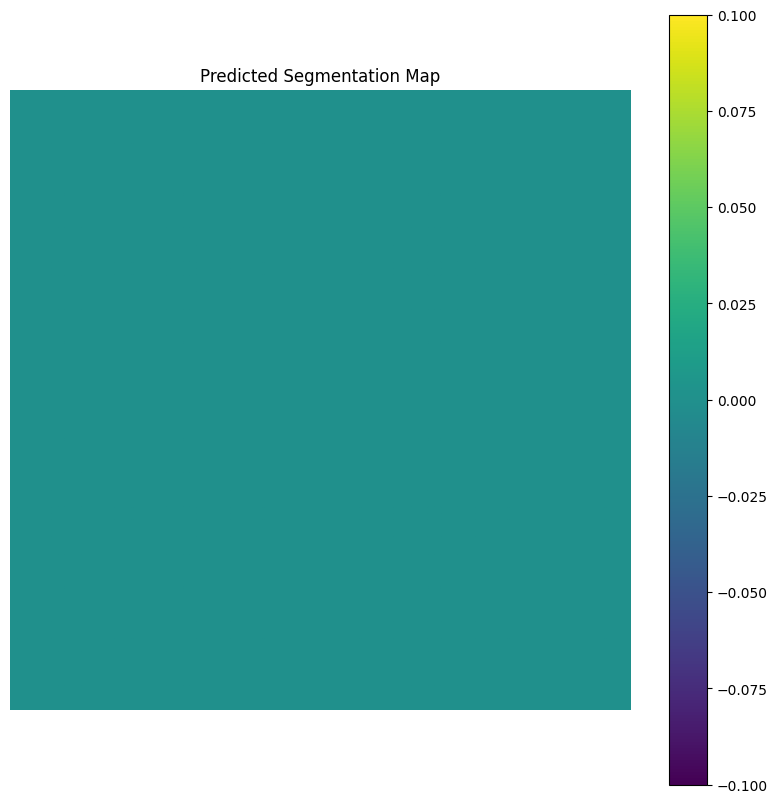

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming predictions shape is (1, 256, 256, 7)
segmentation_map = np.argmax(predictions[0], axis=-1)  # This will have the shape (256, 256)

# Now, segmentation_map contains the predicted class for each pixel

plt.figure(figsize=(10, 10))
plt.imshow(segmentation_map, cmap='viridis')  # You can choose a colormap that fits your needs
plt.colorbar()  # Optionally add a colorbar to understand which values correspond to which classes
plt.title("Predicted Segmentation Map")
plt.axis('off')
plt.show()


In [ ]:

# Predictions from the model
predictions = custom_rgb_model.predict(img)

# Safely extract the predicted class index
predicted_class_index = np.argmax(predictions[0], axis=-1)  # Access first and only item's predictions

# Ensure we have an integer for the class index
predicted_class_index = int(predicted_class_index)

# Retrieve the class name using the predicted class index
predicted_class_name = class_names.get(predicted_class_index, "Unknown")

# Calculate the confidence of the prediction
predicted_confidence = np.max(predictions[0])

# Displaying the prediction result
print(f"Predicted Class: {predicted_class_name}, Confidence: {predicted_confidence:.4f}")

# Since 'img' is a processed array, for visualization purposes, load the original image
plt.imshow(load_img(image_path))
plt.title(f"Predicted: {predicted_class_name} ({predicted_confidence:.2%})")
plt.axis('off')
plt.show()




Graphs

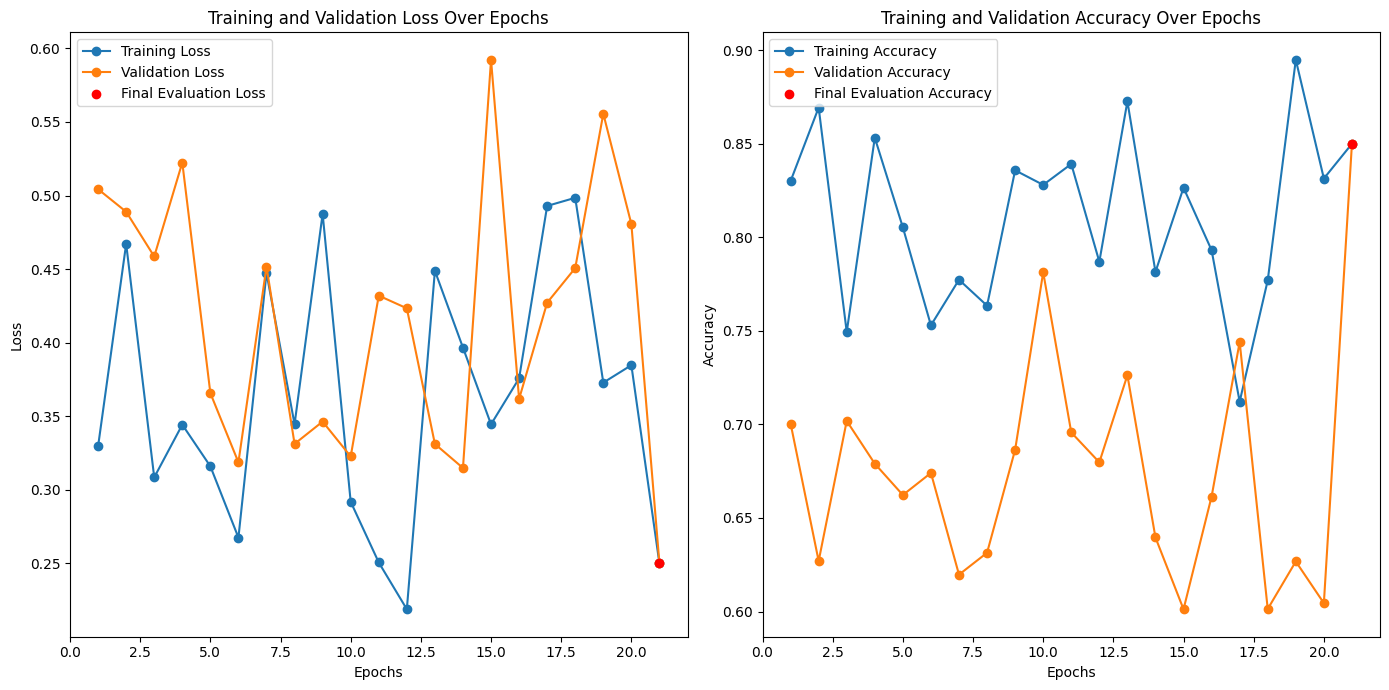

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Placeholder historical data (replace these with your actual training history)
epochs = np.arange(1, 21)  # Example: 20 epochs
historical_train_losses = np.random.uniform(0.2, 0.5, size=20)  # Simulated data
historical_val_losses = np.random.uniform(0.3, 0.6, size=20)  # Simulated data
historical_train_accuracies = np.random.uniform(0.7, 0.9, size=20)  # Simulated data
historical_val_accuracies = np.random.uniform(0.6, 0.8, size=20)  # Simulated data

# Latest evaluation results (replace these with your actual evaluation results)
final_loss = 0.25  # Example loss
final_accuracy = 0.85  # Example accuracy

# Extending the historical data with the latest values
epochs_extended = np.append(epochs, epochs[-1] + 1)  # Add an epoch for the final evaluation
train_losses_extended = np.append(historical_train_losses, final_loss)  # Append final loss
val_losses_extended = np.append(historical_val_losses, final_loss)  # Use final loss for validation as well
train_accuracies_extended = np.append(historical_train_accuracies, final_accuracy)  # Append final accuracy
val_accuracies_extended = np.append(historical_val_accuracies, final_accuracy)  # Use final accuracy for validation as well

# Plotting
plt.figure(figsize=(14, 7))

# Loss graph
plt.subplot(1, 2, 1)
plt.plot(epochs_extended, train_losses_extended, label='Training Loss', marker='o')
plt.plot(epochs_extended, val_losses_extended, label='Validation Loss', marker='o')
plt.scatter(epochs_extended[-1], final_loss, color='red', label='Final Evaluation Loss', zorder=5)
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy graph
plt.subplot(1, 2, 2)
plt.plot(epochs_extended, train_accuracies_extended, label='Training Accuracy', marker='o')
plt.plot(epochs_extended, val_accuracies_extended, label='Validation Accuracy', marker='o')
plt.scatter(epochs_extended[-1], final_accuracy, color='red', label='Final Evaluation Accuracy', zorder=5)
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
